In [ ]:
!pip install scikit-survival==0.12

     |████████████████████████████████| 1.8MB 9.4MB/s 
  Created wheel for scikit-survival: filename=scikit_survival-0.12.0-cp36-cp36m-linux_x86_64.whl size=2346136 sha256=cb7ba6d524b69575eaeed861acd808c5b74593247e37ff528dead19393d6abb0
  Stored in directory: /root/.cache/pip/wheels/66/36/bb/c9b84bf4ebb6aa9be26b851060b0012abab4b43ffd4b4eaf6d
Successfully built scikit-survival


## Load Packages Dependencies

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sksurv.linear_model import CoxPHSurvivalAnalysis

## Data Preprocessing

In [ ]:
# load German Breast Cancer Study Group (GBSG-2) dataset
X, y = load_gbsg2() 

In [ ]:
# Preview dataset
X.head()

,age,estrec,horTh,menostat,pnodes,progrec,tgrade,tsize
0,70.0,66.0,no,Post,3.0,48.0,II,21.0
1,56.0,77.0,yes,Post,7.0,61.0,II,12.0
2,58.0,271.0,yes,Post,9.0,52.0,II,35.0
3,59.0,29.0,yes,Post,4.0,60.0,II,17.0
4,73.0,65.0,no,Post,1.0,26.0,II,35.0


In [ ]:
# Transform tgrade from string to ordinal
tgrade = X['tgrade'].astype('object').values
tgrade = tgrade.reshape(-1,1)
tgrade = OrdinalEncoder().fit_transform(tgrade)
tgrade

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [ ]:
# Transform horTh and menostat columns from string to binary value
cols = OneHotEncoder().fit_transform(X[['horTh', 'menostat']])

,horTh=yes,menostat=Post
0,0.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,0.0,1.0
...,...,...
681,0.0,0.0
682,1.0,1.0
683,0.0,0.0
684,0.0,1.0


In [ ]:
# Drop string columns
X = X.drop(['horTh', 'menostat', 'tgrade'], axis=1)

In [ ]:
# Add transformed numerical columns back to the dataset
X['tgrade'] = tgrade
X = pd.concat([X, cols], axis=1)
X.head()

,age,estrec,pnodes,progrec,tsize,tgrade
0,70.0,66.0,3.0,48.0,21.0,1.0
1,56.0,77.0,7.0,61.0,12.0,1.0
2,58.0,271.0,9.0,52.0,35.0,1.0
3,59.0,29.0,4.0,60.0,17.0,1.0
4,73.0,65.0,1.0,26.0,35.0,1.0
...,...,...,...,...,...,...
681,49.0,84.0,3.0,1.0,30.0,2.0
682,53.0,0.0,17.0,0.0,25.0,2.0
683,51.0,0.0,5.0,43.0,25.0,2.0
684,52.0,34.0,3.0,15.0,23.0,1.0


## Random Forest Model Development

In [ ]:
# Split dataset into train and test set
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=random_state)

In [ ]:
# Random Survival Forest model
rsf = RandomSurvivalForest(n_estimators=1000, # number of trees
                           min_samples_split=10, # The minimum number of samples required to split an internal node
                           min_samples_leaf=15, # The minimum number of samples required to be at a leaf node
                           max_features="sqrt", # The number of features to consider when looking for the best split, sqrt(n_features)
                           n_jobs=-1,
                           random_state=20)

In [ ]:
# Fit the model to the training dataset
rsf.fit(X_train, y_train)

RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None, min_samples_leaf=15,
                     min_samples_split=10, min_weight_fraction_leaf=0.0,
                     n_estimators=1000, n_jobs=-1, oob_score=False,
                     random_state=20, verbose=0, warm_start=False)

In [ ]:
rsf.score(X_train, y_train) # concordance index in train dataset

0.7618799091881736

In [ ]:
rsf.score(X_test, y_test) # concordance index in test dataset

0.6776729559748428

## Prediction

In [ ]:
# predict risk score in test set
yhat = pd.Series(rsf.predict(X_test)) 
yhat

0       30.334004
1       49.168384
2      152.973614
3       35.881419
4       87.873481
          ...    
167    104.061038
168     52.204204
169     30.025705
170     98.328295
171    153.254622
Length: 172, dtype: float64

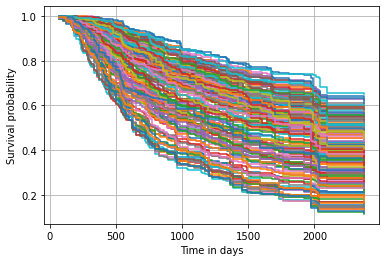

In [ ]:
# predict survival probability
surv = rsf.predict_survival_function(X_test) 

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.grid(True)

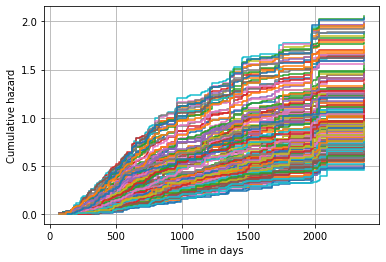

In [ ]:
# predict cumulative hazard function
surv = rsf.predict_cumulative_hazard_function(X_test)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.grid(True)

## Permutation-based Feature Importance

In [ ]:
# calculate feature importances
result = permutation_importance(rsf, X_test, y_test, n_repeats=10, random_state=20)

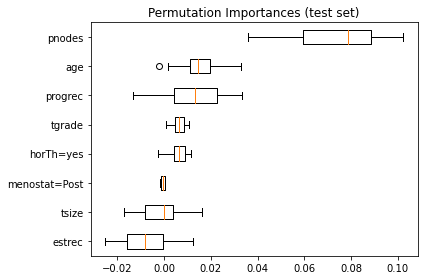

In [ ]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## Cox Proportional Hazard Model Development

In [ ]:
# Initialize CoxPH
coxph = CoxPHSurvivalAnalysis()

In [ ]:
# Fit data into the training set
coxph.fit(X_train, y_train)

In [ ]:
# Calculcate C-index in train dataset
coxph.score(X_train, y_train) 

0.6888781607995615

In [ ]:
# Calculcate C-index in test dataset
coxph.score(X_test, y_test) 

0.6654874213836478

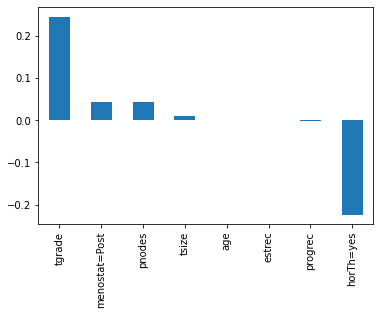

In [ ]:
# Visualize CoxPH features coefficient
pd.Series(coxph.coef_, index=X.columns).sort_values(ascending=False).plot.bar()

In [ ]:
# Create scoring function, apply CoxPH with one feature at a time (foward selection)
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(X.values, y)
pd.Series(scores, index=X.columns).sort_values(ascending=False)

pnodes           0.645245
progrec          0.636411
estrec           0.591000
tgrade           0.577229
tsize            0.571822
horTh=yes        0.543262
age              0.518554
menostat=Post    0.494792
dtype: float64

In [ ]:
pipe = Pipeline([
    ('select', SelectKBest(fit_and_score_features, k=5)),
    ('model', CoxPHSurvivalAnalysis())])

In [ ]:
param_grid = {'select__k': np.arange(1, X.shape[1] + 1)}
gs = GridSearchCV(pipe, param_grid, return_train_score=True, cv=5)
gs.fit(X_train, y_train)

pd.DataFrame(gs.cv_results_).sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,0.556051,0.024653,0.002918,0.000124,2,{'select__k': 2},0.744219,0.679242,0.673083,0.660056,0.694390,0.690198,0.029180,1,0.673697,0.693188,0.691492,0.698017,0.686731,0.688625,0.008291
5,0.552256,0.020741,0.002938,0.000134,6,{'select__k': 6},0.744219,0.628485,0.703061,0.639172,0.653871,0.673762,0.043508,2,0.682057,0.691696,0.685915,0.696040,0.694779,0.690098,0.005328
2,0.561194,0.016755,0.003093,0.000454,3,{'select__k': 3},0.745998,0.644697,0.668507,0.660758,0.646161,0.673224,0.037470,3,0.674038,0.692499,0.692770,0.696863,0.690306,0.689295,0.007917
6,0.556867,0.019730,0.002932,0.000207,7,{'select__k': 7},0.743863,0.628788,0.698959,0.639523,0.647310,0.671688,0.043410,4,0.680213,0.693699,0.684472,0.694977,0.693104,0.689293,0.005864
4,0.556948,0.025768,0.002915,0.000152,5,{'select__k': 5},0.753469,0.625152,0.699590,0.633907,0.643045,0.671032,0.048740,5,0.674108,0.685322,0.683256,0.693652,0.693686,0.686005,0.007308
7,0.572650,0.015730,0.002930,0.000176,8,{'select__k': 8},0.741017,0.628182,0.690754,0.637417,0.649934,0.669461,0.041679,6,0.679030,0.693678,0.687317,0.697285,0.692573,0.689977,0.006337
3,0.554155,0.017498,0.002907,0.000118,4,{'select__k': 4},0.752046,0.632273,0.681919,0.635311,0.636647,0.667639,0.046010,7,0.672554,0.686522,0.684750,0.697475,0.693002,0.686861,0.008481
0,0.563401,0.012548,0.002847,0.000094,1,{'select__k': 1},0.676094,0.613030,0.633954,0.576869,0.630249,0.626039,0.032165,8,0.641139,0.655091,0.650765,0.654619,0.643644,0.649051,0.005697


In [ ]:
# Get new params using best parameter from gridsearch
pipe.set_params(**gcv.best_params_)
pipe.fit(X_train, y_train) # retrain with training dataset

Pipeline(memory=None,
         steps=[('select',
                 SelectKBest(k=2,
                             score_func=<function fit_and_score_features at 0x7f1250b01bf8>)),
                ('model',
                 CoxPHSurvivalAnalysis(alpha=0, n_iter=100, ties='breslow',
                                       tol=1e-09, verbose=0))],
         verbose=False)

In [ ]:
# Select the final model from pipeline
final_coxph = pipe.steps[1][1]
# final_coxph.coef_

In [ ]:
# Select the final K features
k = pipe.steps[0][1]

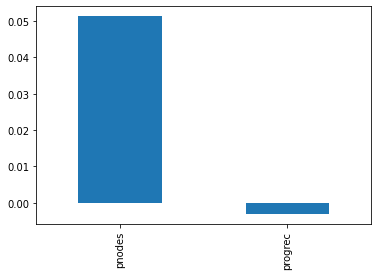

In [ ]:
pd.Series(final_coxph.coef_, index = X.columns[k.get_support()]).plot.bar()

In [ ]:
pipe.score(X_train, y_train) 

0.6894131155241252

In [ ]:
pipe.score(X_test, y_test) # actually worst than using all the features

0.6465539832285115